# Equivalent DistilBert with manual classification head instead of DistilBertforSequenceClassification

### For descriptive purposes only, there is not advantage in using this approach over the hugginface library

In [ ]:
#!pip install transformers

In [1]:
#Imports
from transformers import DistilBertTokenizer, DistilBertConfig, TFDistilBertModel, TFDistilBertForSequenceClassification

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import precision_recall_fscore_support, classification_report

## Helper Functions

In [2]:
# Configs

train_file = "train_80_10_10.csv"
test_file = "test_80_10_10.csv"
val_file = "val_80_10_10.csv"

skip_lines = 6
max_length = 512
split_length = max_length - 2

# DistilBert
bert_file = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(bert_file, do_lower_case=True)
bert_model = TFDistilBertForSequenceClassification.from_pretrained(bert_file)

# Model Training
batch_size = 8
epochs = 3
learning_rate = 2e-5

In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# Function to get data
def get_data(fname):
    df = pd.read_csv(fname)
    df = df[['docid', 'cleaned_contents', 'Discrimination_Label']]
    df = df.rename(columns = {'cleaned_contents':'text', 'Discrimination_Label':'label'})
    df.reset_index(inplace=True, drop=True)
    return df

In [ ]:
# Function to tokenize data and return tensors for input ids, attention mask and labels
def tokenize_plus(df):

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    sentences = df['text'].values
    labels = df['label'].values

    input_ids = []
    input_masks = []
    input_segments = []

    # For every sentence...
    for sent in sentences:
        inputs = tokenizer.encode_plus(sent, 
                                       add_special_tokens=True, 
                                       max_length=max_length, 
                                       truncation = True,
                                       pad_to_max_length=True, 
                                       return_attention_mask=True,
                                       return_token_type_ids=True)

        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])   
    
    labels = df['label']

    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(labels, dtype='int32')

# Fine Tuning and training

In [ ]:
# GET THE DATA
df_train = get_data(train_file)
df_test = get_data(test_file)
df_val = get_data(val_file)

In [ ]:
# Get tokenized labels
input_ids, attention_masks, labels = tokenize_plus(df_train)
val_input_ids, val_attention_masks, val_labels = tokenize_plus(df_val)
test_input_ids, test_attention_masks, test_labels = tokenize_plus(df_test)

In [3]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(bert_file, config = config)

In [4]:
# ADDS A TRAD RELU THEN SOFTMAX LAYER ON TOP OF THE THING
input_ids_in = tf.keras.layers.Input(shape=(512,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(512,), name='masked_token', dtype='int32') 
embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
cls_token = embedding_layer[:,0,:]
#cls_token = embedding_layer[:,0,:]

#X = tf.keras.layers.BatchNormalization()(cls_token)
#X = tf.keras.layers.Dense(64, activation='relu')(X)

X = tf.keras.layers.Dropout(0.2)(cls_token)
X = tf.keras.layers.Dense(2, activation='softmax')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

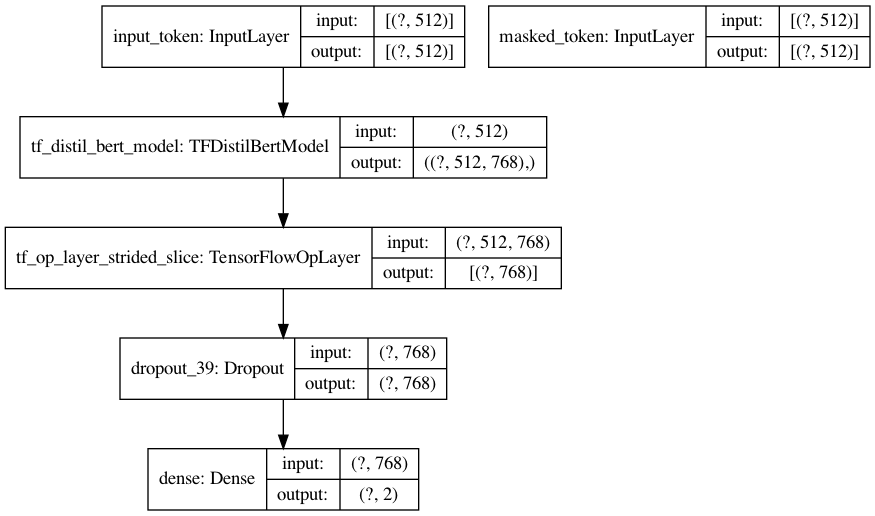

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='DistilBert_TF.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 512, 768),)  66362880    input_token[0][0]                
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, 768)]        0           tf_distil_bert_model[3][0]       
____________________________________________________________________________________________

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti ((None, 512, 768),)  66362880    input_token[0][0]                
__________________________________________________________________________________________________
tf_op_layer_strided_slice_6 (Te [(None, 768)]        0           tf_distil_bert_model_2[4][0]     
____________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
bert_history = model.fit(x = [input_ids, attention_masks], 
                         y = labels,
                         batch_size = 8,
                         epochs = 3, 
                         verbose = 1,
                         validation_data=([val_input_ids, val_attention_masks], val_labels))


#model.fit(inputs,train_y,epochs=1,batch_size=32,validation_split=0.2,shuffle=True)

In [ ]:
# EVALUATE THE MODEL
model.evaluate([test_input_ids, test_attention_masks], test_labels)

3/3 [==============================] - 1s 348ms/step - loss: 0.6127 - accuracy: 0.6543


[0.6126649975776672, 0.654321014881134]

In [ ]:
# Get Predictions
log_pred = model.predict([test_input_ids, test_attention_masks])

In [ ]:
y_pred = np.argmax(log_pred, axis=1)

In [ ]:
# Show classification report
print("DistilBert Manual")
print(classification_report(df_test['label'], y_pred))

DistilBert Manual
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        37
           1       0.75      0.75      0.75        44

    accuracy                           0.73        81
   macro avg       0.73      0.73      0.73        81
weighted avg       0.73      0.73      0.73        81



In [ ]:
y_pred

array([1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
print(df_test['label'].tolist())

[1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]


In [ ]:
# Show classification report
print("DistilBert Manual")
print(classification_report(df_test['label'], y_pred))

DistilBert Manual
              precision    recall  f1-score   support

           0       0.76      0.35      0.48        37
           1       0.62      0.91      0.74        44

    accuracy                           0.65        81
   macro avg       0.69      0.63      0.61        81
weighted avg       0.69      0.65      0.62        81

